# Generative Adversarial Network (GAN)
Now, we've gone through autoencoder, and VAE(Variational autoencoder).
<br>This notebook will go through GAN implementation using PyTorch.
<br>Reference: [GAN in 50 lines of code(PyTorch)](https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f)
<br>![GAN image](https://cdn-images-1.medium.com/max/1600/1*-gFsbymY9oJUQJ-A3GTfeg.png)

To implement GAN, you need to know followings:
- R: The original (Ground truth)
- I: The random noise (source of entropy for generator)
- G: The Generator (imitates the original)
- D: The discriminator (fake/real detector)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
# Define Original
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))    # Mean, std_dev, output_shape

In [3]:
# Define random noise, the entropy for generator
def get_generator_input_sampler():
    return lambda m, n: torch.randn(m, n)    # uniform distribution

In [4]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

In [5]:
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return self.map3(x)    # F.sigmoid(self.map3(x)) if you are using nn.BCELoss()

In [6]:
# GPU/CPU usage check
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
# Extra utils for training
def extract(v):    # to transfer data
    return v.data.storage().tolist()

def stats(d):    # information about uniform distribution
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):    # uniform distribution to range of [0, 1)
    mean = torch.mean(data.data, 1, keepdim=True).to(device)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0]).to(device)
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

In [8]:
# Input data params
data_mean = 4
data_stddev = 1.25

In [9]:
# Hyperparameters
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)
num_epochs = 30000
print_interval = 500
log_interval = 10
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [10]:
name, preprocess, d_input_func = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))

Using data [Data and variances]


In [11]:
# Init training modules
d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCEWithLogitsLoss()    # Binary cross entropy with sigmoid layer combined: https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCEWithLogitsLoss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [12]:
# Apply operation mode
G = G.to(device)
D = D.to(device)
criterion = criterion.to(device)

In [13]:
# Training log
log = {
    'd_real_error': [],
    'd_fake_error': [],
    'g_error': [],
    'real_stddev': [],
    'real_mean': [],
    'fake_stddev': [],
    'fake_mean': [],
    'epochs': []
}

In [14]:
# Training Start
for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(d_sampler(d_input_size)).to(device)
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1, 1)).to(device))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size)).to(device)
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1, 1)).to(device))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size)).to(device)
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1, 1)).to(device))  # we want to fool, so pretend it's all genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters

    if epoch % print_interval == 0:
        print("[Epoch %d]    D: %.4f/%.4f \t G: %.4f" % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0]))
        print("Real: [{:^10.5f}, {:^10.5f}]".format(stats(extract(d_real_data))[0], stats(extract(d_real_data))[1]))
        print("Fake: [{:^10.5f}, {:^10.5f}]".format(stats(extract(d_fake_data))[0], stats(extract(d_fake_data))[1]))
       
    if epoch % log_interval == 0:
        log['epochs'].append(epoch)
        log['d_real_error'].append(extract(d_real_error)[0])
        log['d_fake_error'].append(extract(d_fake_error)[0])
        log['g_error'].append(extract(g_error)[0])
        log['real_mean'].append(stats(extract(d_real_data))[0])
        log['real_stddev'].append(stats(extract(d_real_data))[1])
        log['fake_mean'].append(stats(extract(d_fake_data))[0])
        log['fake_stddev'].append(stats(extract(d_fake_data))[1])

[Epoch 0]    D: 0.8827/0.6494 	 G: 0.7436
Real: [ 4.11856  ,  1.23252  ]
Fake: [ -0.16529 ,  0.00917  ]
[Epoch 500]    D: 0.0203/0.8605 	 G: 0.2996
Real: [ 4.09309  ,  1.30288  ]
Fake: [ 2.06968  ,  0.95464  ]
[Epoch 1000]    D: 0.7377/0.9172 	 G: 1.6566
Real: [ 4.05227  ,  1.18687  ]
Fake: [ 5.15075  ,  1.45214  ]
[Epoch 1500]    D: 0.5561/0.7958 	 G: 0.8077
Real: [ 3.98805  ,  1.20240  ]
Fake: [ 3.60608  ,  1.29222  ]
[Epoch 2000]    D: 0.5837/0.6470 	 G: 0.4591
Real: [ 3.97953  ,  1.26365  ]
Fake: [ 4.35462  ,  1.20709  ]
[Epoch 2500]    D: 0.7408/0.7338 	 G: 0.6542
Real: [ 3.86103  ,  1.25230  ]
Fake: [ 3.54271  ,  1.14475  ]
[Epoch 3000]    D: 0.5516/0.6508 	 G: 0.7186
Real: [ 3.92463  ,  1.30411  ]
Fake: [ 4.30902  ,  1.28408  ]
[Epoch 3500]    D: 0.6722/0.6808 	 G: 0.7744
Real: [ 3.97663  ,  1.20486  ]
Fake: [ 4.08907  ,  1.34767  ]
[Epoch 4000]    D: 0.5522/0.7315 	 G: 0.6268
Real: [ 4.07148  ,  1.09034  ]
Fake: [ 3.82049  ,  1.13634  ]
[Epoch 4500]    D: 0.6686/0.7463 	 G: 0.5

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 8)    # 10 in. x 5 in.

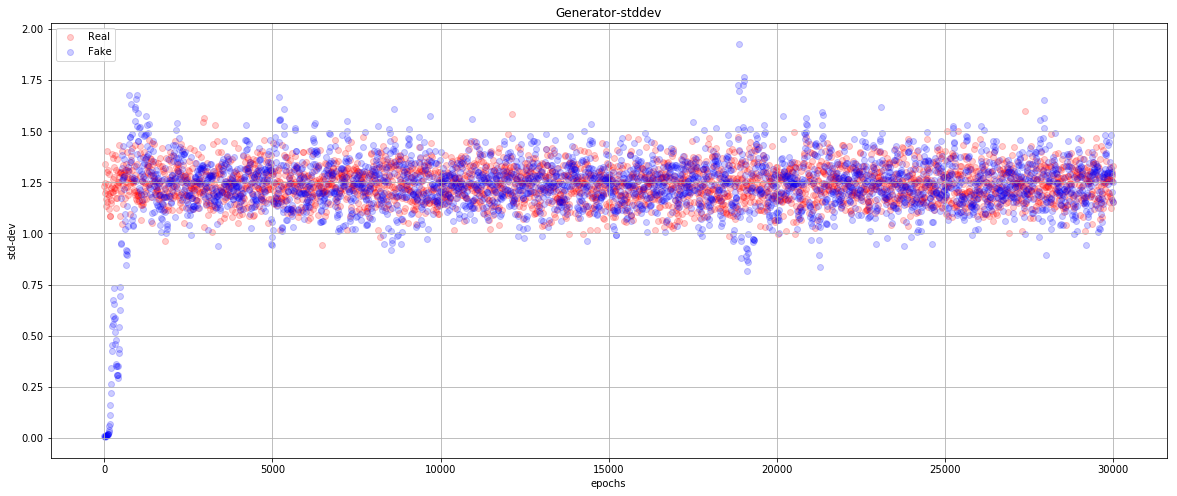

In [24]:
plt.figure()
plt.scatter(log['epochs'], log['real_stddev'], color='r', alpha=0.2, label='Real')
plt.scatter(log['epochs'], log['fake_stddev'], color='b', alpha=0.2, label='Fake')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('std-dev')
plt.title('Generator-stddev')
plt.legend(loc='upper left')
plt.show()

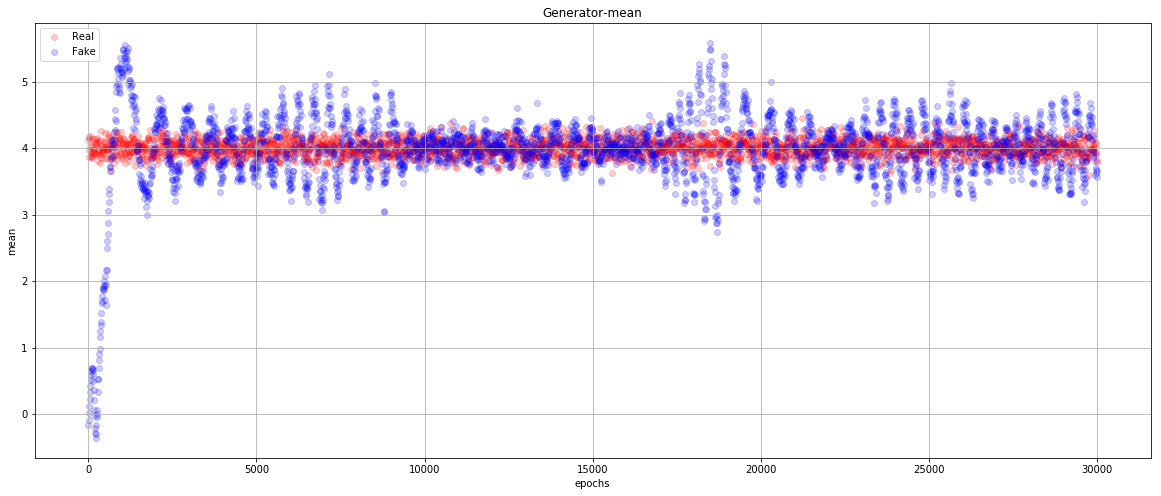

In [25]:
plt.figure()
plt.scatter(log['epochs'], log['real_mean'], color='r', alpha=0.2, label='Real')
plt.scatter(log['epochs'], log['fake_mean'], color='b', alpha=0.2, label='Fake')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('mean')
plt.title('Generator-mean')
plt.legend(loc='upper left')
plt.show()